# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

In [ ]:
# HW2P2 Code and Ablation Log Submission

## Overview

This notebook contains the code and documentation for HW2P2: Image Recognition and Verification. The objective is to train a CNN model for face classification with 8,631 identities and use the extracted face embeddings for image verification.


### 1. Install Dependencies
Ensure you have the required Python packages installed:

pip install torch torchvision tqdm numpy matplotlib wandb


### 2. Run the Notebook
- Locally
  Open and run homework2_part2_submission.ipynb in a Jupyter Notebook environment:
  jupyter notebook homework2_part2_submission.ipynb

or execute the notebook in a Python script using:
  jupyter nbconvert --to script homework2_part2_submission.ipynb
  homework2_part2_submission.py

- Running in Google Colab
  Upload homework2_part2_submission.ipynb to Google Drive.
  Open Google Colab and click File → Open Notebook.
  Open the uploaded notebook.
  If GPU acceleration is needed, navigate to Runtime → Change runtime type and select GPU.
  Run all cells in sequence.


### Model Details
- Architecture: ResNet-based CNN with residual blocks.
- Number of Layers: 5 convolutional layers.
- Activation Function: ReLU.
- Regularization: Batch Normalization, Skip Connections.
- Loss Function: Cross-Entropy Loss with label smoothing (0.1).
- Optimizer: SGD with momentum (0.9) and weight decay (1e-4).
- Scheduler: ReduceLROnPlateau (LR reduction on performance plateau).
- Weight Initialization: Kaiming Normal.
- Training Epochs (Planned): 30.
- Batch Size: 256.
- Learning Rate: 0.1.
- Weight Decay: 1e-4.
- Data Augmentations: Random horizontal flip, rotation, color jitter, affine transformations.
- Learning Rate Reduction:
  * Factor: 0.1
  * Patience: 5 epochs
  * Minimum LR: 1e-6

### Results
- Final Learning Rate: 0.001
- Validation Accuracy: 97.6%
- Equal Error Rate (EER): 2.85%

For more details, refer to:
- WandB Project Link: https://wandb.ai/vmpathak-carnegie-mellon-university/hw2p2?nw=nwuservmpathak
- Ablations Sheet: Included in the handin.tar file

Author: Vishakha Pathak



# Libraries

In [ ]:
!nvidia-smi

Fri Feb 28 05:27:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |   8147MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb --quiet
!pip install pytorch_metric_learning --quiet

In [ ]:
!pip install torchsummary --quiet
!pip install torchvision --quiet

TODO: Change Imports based on new dataset

In [ ]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
#from google.colab import drive # Link to your drive if you are not using Colab with GCP
#drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"vishakhapathak18","key":"5f212c500556779279ca065e3bedca10"}')

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-spring-2025
!unzip -qo '11785-hw-2-p-2-face-verification-spring-2025' -d '/content/data'

mkdir: cannot create directory ‘/content/data’: File exists
11785-hw-2-p-2-face-verification-spring-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


# Config

In [ ]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'epochs': 30, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': "/content/data/HW2p2_S25/cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': "/content/data/HW2p2_S25/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "/content/data/HW2p2_S25/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "/content/data/HW2p2_S25/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "/content/data/checkpoints", #TODO: Checkpoint directory
    'augument': True,
    "weight_initialization": "kaiming_normal",
    "channels": [48, 96, 96, 192, 384],
    "kernels" : [5, 3, 3, 3, 3],
    "strides" : [3, 2, 1, 1, 1],
    "lr": 0.1,
    "weight_decay": 1e-4,
    "label_smoothing": 0.1
    # Include other parameters as needed.
}

# Dataset

In [ ]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
      transform_list.extend([
          T.RandomHorizontalFlip(p=0.5),
          T.RandomRotation(degrees=10),
          T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
          T.RandomAffine(degrees=0, translate=(0.1, 0.1))
      ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py:2299: UserWarning: Run (cwa9syk4) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),


8756

In [ ]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Datasets
cls_train_dataset = ImageDataset(root=os.path.join(config["cls_data_dir"],"train"), transform=train_transforms)
cls_val_dataset   = ImageDataset(root=os.path.join(config["cls_data_dir"],"dev"), transform=val_transforms)
cls_test_dataset  = ImageDataset(root=os.path.join(config["cls_data_dir"],"test"), transform=val_transforms)

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 43155/43155 [00:00<00:00, 444793.58it/s]


## Verification Dataset and Datatloaders

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [ ]:
# Datasets
ver_val_dataset  = ImagePairDataset(root=config['ver_data_dir'], pairs_file=config['val_pairs_file'], transform=val_transforms)
ver_test_dataset = TestImagePairDataset(root=config['ver_data_dir'], pairs_file=config['test_pairs_file'], transform=val_transforms)

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs: 100%|██████████| 6000/6000 [00:05<00:00, 1030.56it/s]


## Create Dataloaders for Image Recognition

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  256
Train batches        :  1686
Val batches          :  169


###Classification Dataset Viz

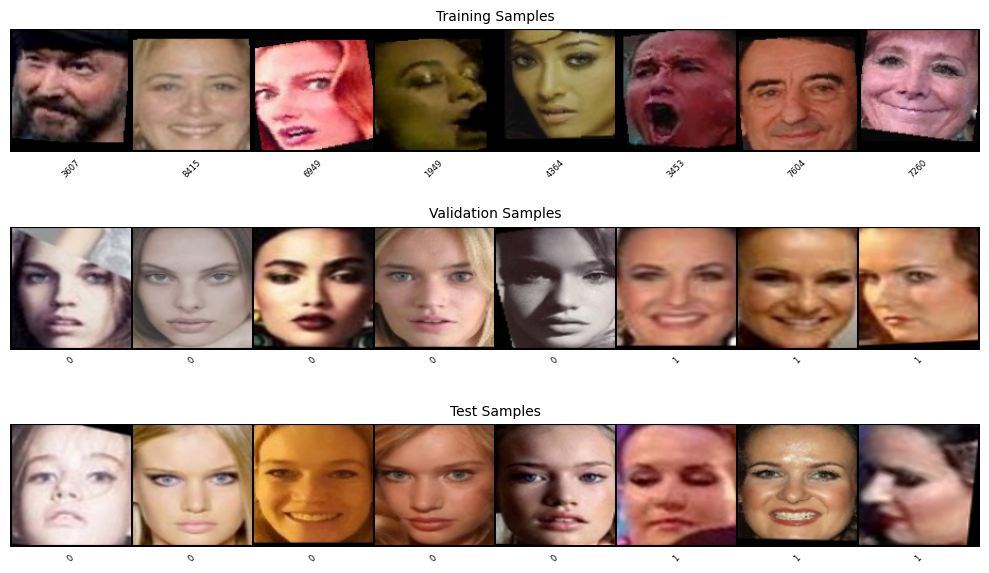

In [ ]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

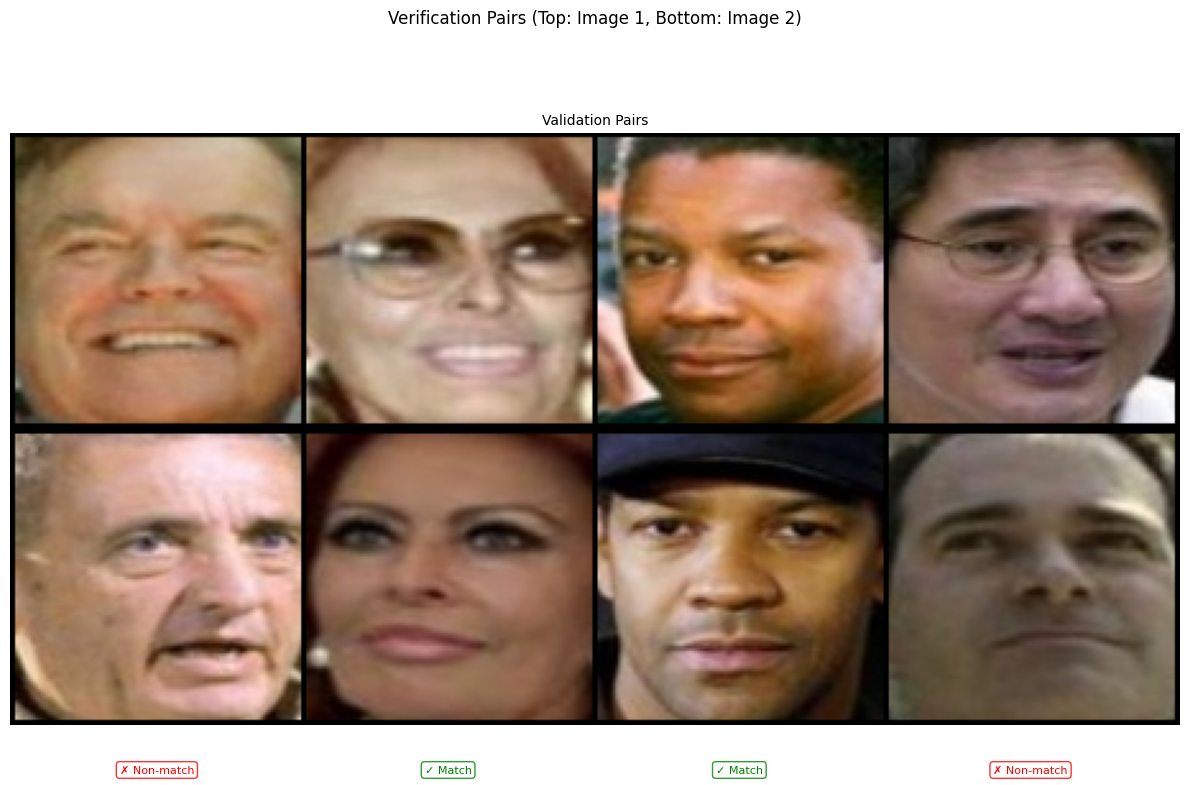

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class ResidualBlock(nn.Module):
    """
    Residual block used in ResNet with an expansion factor of 4.
    """
    expansion = 4

    def __init__(self, in_channels, mid_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mid_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        return self.relu(out)

class ResNet(nn.Module):
    """
    ResNet implementation with 5 layers based on config["channels"].
    """
    def __init__(self, block, num_classes, input_channels=3):
        super(ResNet, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, config["channels"][0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(config["channels"][0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(block, config["channels"][1], blocks=3, stride=1)
        self.layer2 = self._make_layer(block, config["channels"][2], blocks=4, stride=2)
        self.layer3 = self._make_layer(block, config["channels"][3], blocks=6, stride=2)
        self.layer4 = self._make_layer(block, config["channels"][4], blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(config["channels"][4] * block.expansion, num_classes)

        self.initialize_weights()

    def _make_layer(self, block, mid_channels, blocks, stride):
        """
        Creates a layer composed of multiple residual blocks using Sequential.
        """
        downsample = None
        if stride != 1 or self.in_channels != mid_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, mid_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(mid_channels * block.expansion)
            )

        layers = [block(self.in_channels, mid_channels, stride, downsample)]
        self.in_channels = mid_channels * block.expansion  # Update in_channels after downsampling

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, mid_channels))

        return nn.Sequential(*layers)

    def initialize_weights(self):
        """
        Initialize weights using Kaiming Normal.
        """
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if hasattr(m, "bias") and m.bias is not None:
                    m.bias.data.zero_()

    @property
    def in_channels(self):
        """
        Getter for in_channels.
        """
        if not hasattr(self, '_in_channels'):
            self._in_channels = config["channels"][0]
        return self._in_channels

    @in_channels.setter
    def in_channels(self, value):
        """
        Setter for in_channels.
        """
        self._in_channels = value

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        out = self.fc(feats)

        return {"feats": feats, "out": out}


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(ResidualBlock, num_classes=config["num_classes"]).to(DEVICE)

# Model Summary
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 56, 56]           7,056
       BatchNorm2d-2           [-1, 48, 56, 56]              96
              ReLU-3           [-1, 48, 56, 56]               0
         MaxPool2d-4           [-1, 48, 28, 28]               0
            Conv2d-5           [-1, 96, 28, 28]           4,608
       BatchNorm2d-6           [-1, 96, 28, 28]             192
              ReLU-7           [-1, 96, 28, 28]               0
            Conv2d-8           [-1, 96, 28, 28]          82,944
       BatchNorm2d-9           [-1, 96, 28, 28]             192
             ReLU-10           [-1, 96, 28, 28]               0
           Conv2d-11          [-1, 384, 28, 28]          36,864
      BatchNorm2d-12          [-1, 384, 28, 28]             768
           Conv2d-13          [-1, 384, 28, 28]          18,432
      BatchNorm2d-14          [-1, 384,

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=config["label_smoothing"]) # TODO: Use a good loss function

# --------------------------------------------------- #

# Defining Optimizer
optimizer =  torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9, weight_decay=config["weight_decay"]) # TODO: Use a good optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, threshold = 1e-2, min_lr = 1e-6) # TODO: Use a good scheduler

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    # if lr_scheduler is not None:
    #     lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']


# WandB

In [ ]:
wandb.login(key="6000248c014f1c7f1252913b5c6b754aa8211d49") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import wandb

if wandb.run is not None:
    wandb.finish()  # Ensures the previous run is properly closed

run = wandb.init(
    name="vmpathak_test",
    reinit=True,
    project="hw2p2",
    config=config
)

train_cls_acc,▁▁█
train_loss,█▆▁
valid_cls_acc,▁▂█
valid_loss,█▅▁
valid_ret_acc,▁▆█
train_cls_acc,1.36962
train_loss,7.54914
valid_cls_acc,3.05036
valid_loss,7.07037
valid_ret_acc,89


# Checkpointing and Loading Model

In [ ]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [ ]:
torch.cuda.empty_cache()

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        scheduler.step(valid_ret_acc)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/30: 
Train Cls. Acc 7.1270%	 Train Cls. Loss 6.2268	 Learning Rate 0.1000


Val Cls. Acc 9.9398%	 Val Cls. Loss 5.9107


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 91.4, 'EER': 9.164969450102314, 'AUC': 96.15195323284745, 'TPRs': [('TPR@FPR=1e-4', 29.735234215885946), ('TPR@FPR=5e-4', 29.735234215885946), ('TPR@FPR=1e-3', 29.735234215885946), ('TPR@FPR=5e-3', 41.54786150712831), ('TPR@FPR=5e-2', 86.76171079429736)]}
Val Ret. Acc 91.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 2/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/30: 
Train Cls. Acc 17.4444%	 Train Cls. Loss 5.3160	 Learning Rate 0.1000


Val Cls. Acc 16.6877%	 Val Cls. Loss 5.5214


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 92.0, 'EER': 8.553971486789045, 'AUC': 97.0650490759006, 'TPRs': [('TPR@FPR=1e-4', 41.34419551934827), ('TPR@FPR=5e-4', 41.34419551934827), ('TPR@FPR=1e-3', 41.34419551934827), ('TPR@FPR=5e-3', 58.85947046843177), ('TPR@FPR=5e-2', 87.9837067209776)]}
Val Ret. Acc 92.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/30: 
Train Cls. Acc 31.2262%	 Train Cls. Loss 4.4993	 Learning Rate 0.1000


Val Cls. Acc 34.2890%	 Val Cls. Loss 4.3739


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 94.6, 'EER': 5.702647657841144, 'AUC': 98.30625122539703, 'TPRs': [('TPR@FPR=1e-4', 72.50509164969449), ('TPR@FPR=5e-4', 72.50509164969449), ('TPR@FPR=1e-3', 72.50509164969449), ('TPR@FPR=5e-3', 80.24439918533605), ('TPR@FPR=5e-2', 93.48268839103869)]}
Val Ret. Acc 94.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/30: 
Train Cls. Acc 43.8010%	 Train Cls. Loss 3.8734	 Learning Rate 0.1000


Val Cls. Acc 42.6005%	 Val Cls. Loss 3.9571


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 95.2, 'EER': 5.295315682280938, 'AUC': 98.4238893401462, 'TPRs': [('TPR@FPR=1e-4', 61.30346232179226), ('TPR@FPR=5e-4', 61.30346232179226), ('TPR@FPR=1e-3', 61.30346232179226), ('TPR@FPR=5e-3', 62.52545824847251), ('TPR@FPR=5e-2', 94.70468431771894)]}
Val Ret. Acc 95.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/30: 
Train Cls. Acc 53.3043%	 Train Cls. Loss 3.4362	 Learning Rate 0.1000


Val Cls. Acc 45.8606%	 Val Cls. Loss 3.7850


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 95.4, 'EER': 5.091649694501023, 'AUC': 98.36266950491958, 'TPRs': [('TPR@FPR=1e-4', 64.96945010183299), ('TPR@FPR=5e-4', 64.96945010183299), ('TPR@FPR=1e-3', 64.96945010183299), ('TPR@FPR=5e-3', 84.72505091649694), ('TPR@FPR=5e-2', 94.90835030549898)]}
Val Ret. Acc 95.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/30: 
Train Cls. Acc 59.6304%	 Train Cls. Loss 3.1521	 Learning Rate 0.1000


Val Cls. Acc 55.8063%	 Val Cls. Loss 3.3568


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 95.8, 'EER': 4.4806517311616885, 'AUC': 98.50831669460905, 'TPRs': [('TPR@FPR=1e-4', 76.78207739307535), ('TPR@FPR=5e-4', 76.78207739307535), ('TPR@FPR=1e-3', 76.78207739307535), ('TPR@FPR=5e-3', 82.4847250509165), ('TPR@FPR=5e-2', 95.72301425661914)]}
Val Ret. Acc 95.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/30: 
Train Cls. Acc 64.4637%	 Train Cls. Loss 2.9392	 Learning Rate 0.1000


Val Cls. Acc 59.9621%	 Val Cls. Loss 3.1870


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 96.0, 'EER': 4.51866404715337, 'AUC': 98.68077257031278, 'TPRs': [('TPR@FPR=1e-4', 81.05906313645622), ('TPR@FPR=5e-4', 81.05906313645622), ('TPR@FPR=1e-3', 81.05906313645622), ('TPR@FPR=5e-3', 86.15071283095723), ('TPR@FPR=5e-2', 95.72301425661914)]}
Val Ret. Acc 96.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/30: 
Train Cls. Acc 67.9836%	 Train Cls. Loss 2.7832	 Learning Rate 0.1000


Val Cls. Acc 61.8549%	 Val Cls. Loss 3.1054


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 96.2, 'EER': 4.276985743380861, 'AUC': 98.82882053785426, 'TPRs': [('TPR@FPR=1e-4', 73.11608961303462), ('TPR@FPR=5e-4', 73.11608961303462), ('TPR@FPR=1e-3', 73.11608961303462), ('TPR@FPR=5e-3', 89.40936863543789), ('TPR@FPR=5e-2', 96.94501018329939)]}
Val Ret. Acc 96.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/30: 
Train Cls. Acc 70.7848%	 Train Cls. Loss 2.6625	 Learning Rate 0.1000


Val Cls. Acc 64.4679%	 Val Cls. Loss 2.9920


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 95.7, 'EER': 4.71512770141125, 'AUC': 98.79480951828393, 'TPRs': [('TPR@FPR=1e-4', 81.87372708757637), ('TPR@FPR=5e-4', 81.87372708757637), ('TPR@FPR=1e-3', 81.87372708757637), ('TPR@FPR=5e-3', 86.9653767820774), ('TPR@FPR=5e-2', 95.5193482688391)]}
Val Ret. Acc 95.7000%
Saved epoch model
Saved best classification model

Epoch 10/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/30: 
Train Cls. Acc 73.0962%	 Train Cls. Loss 2.5612	 Learning Rate 0.1000


Val Cls. Acc 63.5335%	 Val Cls. Loss 3.0301


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 96.2, 'EER': 4.073319755602339, 'AUC': 98.59794573441795, 'TPRs': [('TPR@FPR=1e-4', 82.07739307535643), ('TPR@FPR=5e-4', 82.07739307535643), ('TPR@FPR=1e-3', 82.07739307535643), ('TPR@FPR=5e-3', 91.0386965376782), ('TPR@FPR=5e-2', 96.13034623217924)]}
Val Ret. Acc 96.2000%
Saved epoch model
Saved best retrieval model

Epoch 11/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/30: 
Train Cls. Acc 75.0917%	 Train Cls. Loss 2.4800	 Learning Rate 0.1000


Val Cls. Acc 66.9595%	 Val Cls. Loss 2.8730


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 96.3, 'EER': 4.4806517311604335, 'AUC': 98.26063644620857, 'TPRs': [('TPR@FPR=1e-4', 81.67006109979633), ('TPR@FPR=5e-4', 81.67006109979633), ('TPR@FPR=1e-3', 81.67006109979633), ('TPR@FPR=5e-3', 88.59470468431772), ('TPR@FPR=5e-2', 95.72301425661914)]}
Val Ret. Acc 96.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/30: 
Train Cls. Acc 76.6062%	 Train Cls. Loss 2.4127	 Learning Rate 0.1000


Val Cls. Acc 65.0113%	 Val Cls. Loss 2.9466


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 96.2, 'EER': 3.8696537678203864, 'AUC': 98.56113380735358, 'TPRs': [('TPR@FPR=1e-4', 69.24643584521385), ('TPR@FPR=5e-4', 69.24643584521385), ('TPR@FPR=1e-3', 69.24643584521385), ('TPR@FPR=5e-3', 89.20570264765783), ('TPR@FPR=5e-2', 96.33401221995926)]}
Val Ret. Acc 96.2000%
Saved epoch model

Epoch 13/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/30: 
Train Cls. Acc 91.0440%	 Train Cls. Loss 1.8774	 Learning Rate 0.0100


Val Cls. Acc 83.8450%	 Val Cls. Loss 2.1873


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.2, 'EER': 3.462321792224944, 'AUC': 98.69157607064687, 'TPRs': [('TPR@FPR=1e-4', 83.29938900203666), ('TPR@FPR=5e-4', 83.29938900203666), ('TPR@FPR=1e-3', 83.29938900203666), ('TPR@FPR=5e-3', 94.29735234215886), ('TPR@FPR=5e-2', 97.14867617107943)]}
Val Ret. Acc 97.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/30: 
Train Cls. Acc 93.3239%	 Train Cls. Loss 1.7858	 Learning Rate 0.0100


Val Cls. Acc 84.6909%	 Val Cls. Loss 2.1566


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.2, 'EER': 3.1434184676005885, 'AUC': 98.68477386673283, 'TPRs': [('TPR@FPR=1e-4', 81.26272912423626), ('TPR@FPR=5e-4', 81.26272912423626), ('TPR@FPR=1e-3', 81.26272912423626), ('TPR@FPR=5e-3', 93.27902240325867), ('TPR@FPR=5e-2', 96.94501018329939)]}
Val Ret. Acc 97.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/30: 
Train Cls. Acc 94.1981%	 Train Cls. Loss 1.7509	 Learning Rate 0.0100


Val Cls. Acc 85.1295%	 Val Cls. Loss 2.1378


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.3, 'EER': 3.143418467605377, 'AUC': 98.77160199904769, 'TPRs': [('TPR@FPR=1e-4', 83.29938900203666), ('TPR@FPR=5e-4', 83.29938900203666), ('TPR@FPR=1e-3', 83.29938900203666), ('TPR@FPR=5e-3', 94.29735234215886), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 16/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/30: 
Train Cls. Acc 94.9418%	 Train Cls. Loss 1.7244	 Learning Rate 0.0100


Val Cls. Acc 85.3745%	 Val Cls. Loss 2.1264


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 3.0549898167310143, 'AUC': 98.82962079713826, 'TPRs': [('TPR@FPR=1e-4', 79.83706720977597), ('TPR@FPR=5e-4', 79.83706720977597), ('TPR@FPR=1e-3', 79.83706720977597), ('TPR@FPR=5e-3', 93.89002036659878), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/30: 
Train Cls. Acc 95.3685%	 Train Cls. Loss 1.7046	 Learning Rate 0.0100


Val Cls. Acc 85.6235%	 Val Cls. Loss 2.1135


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.8, 'EER': 2.85132382892399, 'AUC': 98.86803324277066, 'TPRs': [('TPR@FPR=1e-4', 83.09572301425662), ('TPR@FPR=5e-4', 83.09572301425662), ('TPR@FPR=1e-3', 83.09572301425662), ('TPR@FPR=5e-3', 93.27902240325867), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 18/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/30: 
Train Cls. Acc 95.8085%	 Train Cls. Loss 1.6879	 Learning Rate 0.0100


Val Cls. Acc 85.6426%	 Val Cls. Loss 2.1124


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.3, 'EER': 3.1434184674946732, 'AUC': 98.8516279274485, 'TPRs': [('TPR@FPR=1e-4', 79.83706720977597), ('TPR@FPR=5e-4', 79.83706720977597), ('TPR@FPR=1e-3', 79.83706720977597), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.3000%
Saved epoch model
Saved best classification model

Epoch 19/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/30: 
Train Cls. Acc 96.1493%	 Train Cls. Loss 1.6731	 Learning Rate 0.0100


Val Cls. Acc 85.8767%	 Val Cls. Loss 2.1018


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 3.054989816700526, 'AUC': 98.88203778024081, 'TPRs': [('TPR@FPR=1e-4', 82.68839103869654), ('TPR@FPR=5e-4', 82.68839103869654), ('TPR@FPR=1e-3', 82.68839103869654), ('TPR@FPR=5e-3', 93.68635437881873), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model

Epoch 20/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/30: 
Train Cls. Acc 97.0321%	 Train Cls. Loss 1.6380	 Learning Rate 0.0010


Val Cls. Acc 86.3245%	 Val Cls. Loss 2.0831


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.5, 'EER': 2.8513238289258314, 'AUC': 98.82842040821225, 'TPRs': [('TPR@FPR=1e-4', 82.28105906313645), ('TPR@FPR=5e-4', 82.28105906313645), ('TPR@FPR=1e-3', 82.28105906313645), ('TPR@FPR=5e-3', 94.90835030549898), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.5000%
Saved epoch model
Saved best classification model

Epoch 21/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/30: 
Train Cls. Acc 97.1677%	 Train Cls. Loss 1.6314	 Learning Rate 0.0010


Val Cls. Acc 86.3413%	 Val Cls. Loss 2.0797


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.7, 'EER': 2.8513238289384986, 'AUC': 98.85562922386853, 'TPRs': [('TPR@FPR=1e-4', 82.4847250509165), ('TPR@FPR=5e-4', 82.4847250509165), ('TPR@FPR=1e-3', 82.4847250509165), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 22/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 22/30: 
Train Cls. Acc 97.2630%	 Train Cls. Loss 1.6284	 Learning Rate 0.0010


Val Cls. Acc 86.4146%	 Val Cls. Loss 2.0785


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.5, 'EER': 2.8513238289362044, 'AUC': 98.84522585317643, 'TPRs': [('TPR@FPR=1e-4', 82.89205702647658), ('TPR@FPR=5e-4', 82.89205702647658), ('TPR@FPR=1e-3', 82.89205702647658), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.5000%
Saved epoch model
Saved best classification model

Epoch 23/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 23/30: 
Train Cls. Acc 97.2869%	 Train Cls. Loss 1.6260	 Learning Rate 0.0010


Val Cls. Acc 86.3476%	 Val Cls. Loss 2.0777


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 2.8513238289362044, 'AUC': 98.86123103885659, 'TPRs': [('TPR@FPR=1e-4', 82.89205702647658), ('TPR@FPR=5e-4', 82.89205702647658), ('TPR@FPR=1e-3', 82.89205702647658), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.6000%
Saved epoch model

Epoch 24/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 24/30: 
Train Cls. Acc 97.3157%	 Train Cls. Loss 1.6248	 Learning Rate 0.0010


Val Cls. Acc 86.5210%	 Val Cls. Loss 2.0745


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 2.8513238289340848, 'AUC': 98.84162468639839, 'TPRs': [('TPR@FPR=1e-4', 83.29938900203666), ('TPR@FPR=5e-4', 83.29938900203666), ('TPR@FPR=1e-3', 83.29938900203666), ('TPR@FPR=5e-3', 94.09368635437882), ('TPR@FPR=5e-2', 97.35234215885947)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model

Epoch 25/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 25/30: 
Train Cls. Acc 97.3744%	 Train Cls. Loss 1.6228	 Learning Rate 0.0010


Val Cls. Acc 86.4453%	 Val Cls. Loss 2.0755


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.7, 'EER': 2.8513238289325464, 'AUC': 98.84122455675639, 'TPRs': [('TPR@FPR=1e-4', 82.89205702647658), ('TPR@FPR=5e-4', 82.89205702647658), ('TPR@FPR=1e-3', 82.89205702647658), ('TPR@FPR=5e-3', 94.5010183299389), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.7000%
Saved epoch model

Epoch 26/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 26/30: 
Train Cls. Acc 97.4778%	 Train Cls. Loss 1.6187	 Learning Rate 0.0001


Val Cls. Acc 86.4840%	 Val Cls. Loss 2.0750


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 2.8513238289373244, 'AUC': 98.85082766816447, 'TPRs': [('TPR@FPR=1e-4', 82.68839103869654), ('TPR@FPR=5e-4', 82.68839103869654), ('TPR@FPR=1e-3', 82.68839103869654), ('TPR@FPR=5e-3', 94.5010183299389), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.6000%
Saved epoch model

Epoch 27/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 27/30: 
Train Cls. Acc 97.4469%	 Train Cls. Loss 1.6193	 Learning Rate 0.0001


Val Cls. Acc 86.4770%	 Val Cls. Loss 2.0741


Val Veri.:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'ACC': 97.6, 'EER': 2.8513238289373244, 'AUC': 98.86043077957258, 'TPRs': [('TPR@FPR=1e-4', 82.68839103869654), ('TPR@FPR=5e-4', 82.68839103869654), ('TPR@FPR=1e-3', 82.68839103869654), ('TPR@FPR=5e-3', 94.70468431771894), ('TPR@FPR=5e-2', 97.5560081466395)]}
Val Ret. Acc 97.6000%
Saved epoch model

Epoch 28/30


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-152-59d7aeeb523e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train:   0%|          | 2/1686 [00:02<35:00,  1.25s/it, acc=97.6562% (97.6562), loss=1.6149 (1.6081), lr=0.0001]  

KeyboardInterrupt: 

In [ ]:
checkpoint = torch.load("/content/data/checkpoints/best_ret.pth")
model.load_state_dict(checkpoint["model_state_dict"])

<ipython-input-162-261eff886ec0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/data/checkpoints/best_ret.pth")


<All keys matched successfully>

# Testing and Kaggle Submission

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

Val Veri.:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-spring-2025 -f /content/submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 141k/141k [00:00<00:00, 213kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Spring 2025